In [124]:
#standard
import os
import warnings
warnings.filterwarnings('ignore')
import pickle

#third party
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob as glob
from IPython.display import Video

#### This notebook practices loading ROI-specific beta values from versionB MNI152 space and visualizing the (middle frames) of the top k stimuli that maximally activated that specific ROI.
#### This is a rather coarse check to see that, for example, scene-selective ROIs (TOS, PPA, RSC) tend to be strongly activated by stimuli depicting scenes, and face-selective ROIs (FFA, OFA, STS) tend to be strongly activated by stimuli depicting faces. This notebook displays the middle frames of the top k videos but has code at the end to display the full video. The full video often helps make sense of why an ROI might have shown a strong preference for a stimulus. For example, EBA (body selective) might show a strong preference for a video containing lots of limb movements, like punching or juggling or kicking, that aren't obvious just from a frame.

In [138]:
#setup paths
dataset_root = "/your/path/to/BOLDMomentsDataset"
roi = 'EBA' #roi you want to look at
assert(roi in ["V1v","V1d","V2v","V2d","V3v","V3d","hV4","EBA","FFA","OFA","STS","LOC","PPA","RSC","TOS","V3ab","IPS0","IPS1-2-3","7AL","BA2","PFt","PFop","MT"])
hemi = 'both' # 'l' for left, 'r' for right, 'both' for both hemispheres combined
k = 10 #visualize the top k video stimuli that activate this roi

subject = 1 #which subject 1-10 you want to look at
subject = f"sub-{int(subject):02}"

fmri_path = os.path.join(dataset_root,"derivatives", "versionB", "MNI152","prepared_allvoxel_pkl", subject)
frame_path = os.path.join(dataset_root, "derivatives", "stimuli_metadata", "frames_middle") #path to the middle frame of each video. much lighter than dealing with the full video


In [139]:
#load betas
if hemi == 'both':
    print(f"loading both hemisphere data of roi {roi} for subject {subject}")
    with open(os.path.join(fmri_path, f"{subject}_roi-l{roi}_betas_normalized.pkl"), 'rb') as f:
        l_betas_dict = pickle.load(f)
    l_betas_train = l_betas_dict['train_data_allvoxel'].mean(axis=1) #average over reps
    l_betas_test = l_betas_dict['test_data_allvoxel'].mean(axis=1) #average over reps
    l_betas = np.vstack((l_betas_train,l_betas_test)) #shape (n_stimuli, n_voxels) where n_stimuli == 1102

    with open(os.path.join(fmri_path, f"{subject}_roi-r{roi}_betas_normalized.pkl"), 'rb') as f:
        r_betas_dict = pickle.load(f)
    r_betas_train = r_betas_dict['train_data_allvoxel'].mean(axis=1) #average over reps
    r_betas_test = r_betas_dict['test_data_allvoxel'].mean(axis=1) #average over reps
    r_betas = np.vstack((r_betas_train,r_betas_test)) #shape (n_stimuli, n_voxels) where n_stimuli == 1102

    betas = np.hstack((l_betas, r_betas)) # horizontally stack the left and right hemisphere betas into one array. shape (n_stimuli, n_voxels)
elif hemi in ['l','r']:
    print(f"loading {hemi} hemisphere data of roi {roi} for subject {subject}")
    with open(os.path.join(fmri_path, f"{subject}_roi-{hemi}{roi}_betas_normalized.pkl"), 'rb') as f:
        betas_dict = pickle.load(f)
    betas_train = betas_dict['train_data_allvoxel'].mean(axis=1) #average over reps
    betas_test = betas_dict['test_data_allvoxel'].mean(axis=1) #average over reps
    betas = np.vstack((betas_train,betas_test))
else:
    raise ValueError("hemi value not recognized. Must be either 'l', 'r', or 'both'")

print(f"Shape of beta array: {betas.shape}")
assert(betas.shape[0] == 1102)
#average betas values over the voxels in the ROI
betas = np.mean(betas, axis=1)

loading both hemisphere data of roi EBA for subject sub-01
Shape of beta array: (1102, 324)


In [140]:
#find the indices that correspond to the top k beta values in the ROI
sorted_indices = list(np.argsort(betas))
sorted_indices.reverse() #high to low
topk_indices = sorted_indices[:k]
print(topk_indices)

[221, 196, 721, 606, 362, 792, 832, 516, 94, 773]


Displaying top 10 stimuli for subject sub-01 in ROI EBA hemi both


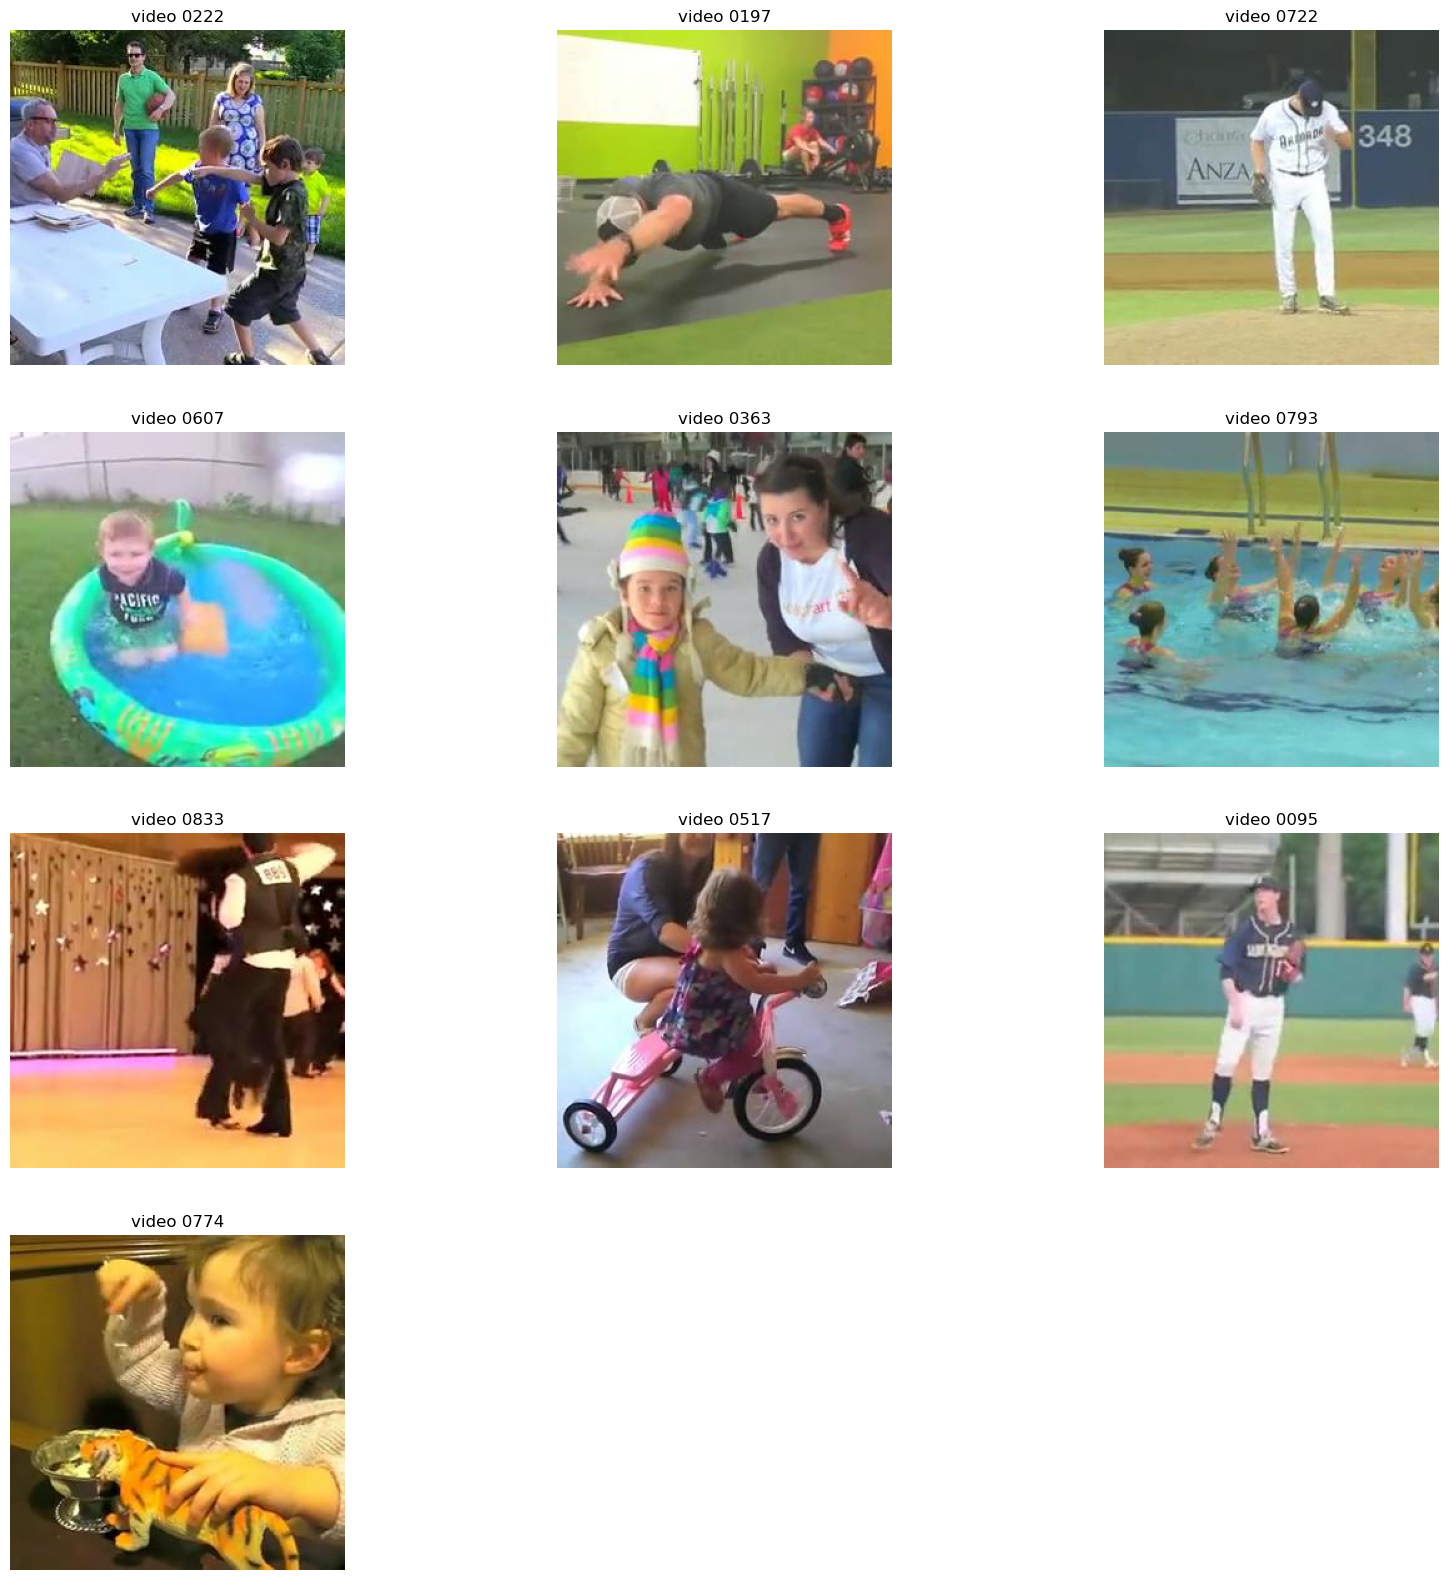

In [141]:
print(f"Displaying top {k} stimuli for subject {subject} in ROI {roi} hemi {hemi}")
#load images
frames = []
for idx in topk_indices:
    filepath = glob.glob(os.path.join(frame_path, f"{idx+1:04}_*.jpg")) #+1 one because the video names start at 1, not 0
    assert(len(filepath) == 1)
    img = Image.open(filepath[0])
    if img is not None:
        frames.append(img)
#display images
width=20
height=20
columns=3
fig = plt.figure(figsize=(width, height))
for i, image in enumerate(frames):
    ax = fig.add_subplot(len(frames) // columns + 1, columns, i + 1)
    ax.imshow(image)
    ax.set_title(f"video {topk_indices[i]+1:04}", fontsize=12)

    ax.axis('off')
plt.show()

In [147]:
#display the video if you want a closer look at a stimulus. 
video_ID = 517 #int
Video(os.path.join(dataset_root, "derivatives", "stimuli_metadata", "mp4_h264", f"{video_ID:04}.mp4"), embed=True)